# Data Exploration

In [1]:
import os #For file paths
import keras_cv #For audio spectrograms and data augmentation. This has some prebuilt models
import keras#Main deep learning framework you’re using to build models, layers, and training loops
import keras.backend as K #“Low-level” backend ops used inside/around Keras models
import tensorflow as tf #TensorFlow is one of the possible “backends” Keras can run on,
import tensorflow_io as tfio #For audio tasks,
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.schedules import CosineDecay

import numpy as np 
import pandas as pd

from glob import glob
from tqdm import tqdm

import librosa #Core audio processing library in Python.
import IPython.display as ipd #For Jupyter/Colab display utilities.
import librosa.display as lid #Plotting helpers for audio from librosa.

import matplotlib.pyplot as plt
import matplotlib as mpl

import random
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
os.environ["KERAS_BACKEND"] = "torch"  # "jax" or "tensorflow" or "torch" 

from collections import defaultdict

2025-12-16 19:34:22.114145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765913662.325294      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765913662.383636      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8str_util8EndsWithESt17basic_string_viewIcSt11char_traitsIcEES4_']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl8str_util9LowercaseB5cxx11ESt17basic_s

In [2]:
train_meta = pd.read_csv('/kaggle/input/birdclef-2024/train_metadata.csv')
eBird_Taxonomy = pd.read_csv('/kaggle/input/birdclef-2024/eBird_Taxonomy_v2021.csv')

In [3]:
#Configuration class to avoid having configuration features accidentally modified
class CFG:
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 512]
    batch_size = 64
    
    # Audio duration, sample rate, and length
    duration = 15 
    sample_rate = 32000 #32 kHz were the downsampled dimensions
    audio_len = duration * sample_rate #douration * sample rate (samples per second)
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 10
    preset = 'efficientnetv2_b2_imagenet'
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24, these are actually bird species (common names)
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2024/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {specs:idx for idx,specs in label2name.items()}

CFG = CFG()

In [4]:
BASE_PATH = '/kaggle/input/birdclef-2024'
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = BASE_PATH + '/train_audio/' + df.filename #Get filepath for the each record
df['target'] = df.primary_label.map(CFG.name2label) #number for each species
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rwos
df

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,XC134896.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC134896
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,XC164848.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC164848
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,XC175797.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC175797
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,XC207738.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC207738
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,XC209218.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC209218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24454,zitcis1,[],[''],43.5925,4.5434,Cisticola juncidis,Zitting Cisticola,Chèvremont Fabian,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/845747,XC845747.ogg,/kaggle/input/birdclef-2024/train_audio/zitcis...,181,XC845747
24455,zitcis1,[],[''],43.5925,4.5434,Cisticola juncidis,Zitting Cisticola,Chèvremont Fabian,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/845817,XC845817.ogg,/kaggle/input/birdclef-2024/train_audio/zitcis...,181,XC845817
24456,zitcis1,[],[''],51.1207,4.5607,Cisticola juncidis,Zitting Cisticola,Wim Jacobs,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/856176,XC856176.ogg,/kaggle/input/birdclef-2024/train_audio/zitcis...,181,XC856176
24457,zitcis1,[],[''],41.5607,-8.4236,Cisticola juncidis,Zitting Cisticola,Jorge Leitão,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://xeno-canto.org/856723,XC856723.ogg,/kaggle/input/birdclef-2024/train_audio/zitcis...,181,XC856723


In [5]:
#Dictionary of species:
labels = df['primary_label'].unique()
species = df['common_name'].unique()
label2species = dict(zip(labels, species))

In [6]:
#Species Visualization:
print(label2species['pursun4'], len(label2species))

Purple Sunbird 182


# Pre-process audio 

In [7]:
AUDIO_DIR = "/kaggle/input/birdclef-2024/train_audio"
OUT_DIR = "/kaggle/working/spec_train"
SPEC_DIR = '/kaggle/input/bird-call-spectrogram-10secs/spec_train'

# Dataset

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

# 1. Gather all file paths and labels
all_npy_paths = []
all_labels = []

# Walk through the output directory to get files and species labels
for species in os.listdir(SPEC_DIR):
    species_dir = os.path.join(SPEC_DIR, species)
    if os.path.isdir(species_dir):
        
        # Get label index from species name
        if species in CFG.name2label:
            label_idx = CFG.name2label[species]
            for fname in os.listdir(species_dir):
                if fname.endswith('.npy'):
                    all_npy_paths.append(os.path.join(species_dir, fname))
                    all_labels.append(label_idx)

In [9]:
path = "/kaggle/input/bird-call-spectrogram-10secs/spec_train/ashdro1/XC114600.npy"

spec = np.load(path)

print(spec.shape)

(128, 512)


In [10]:
# 2. Split into Train and Validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_npy_paths, all_labels, test_size=0.2, random_state=CFG.seed, stratify=all_labels
)

# 3. Define the NPY loader function
def load_npy_data(path, label):
    # Load numpy file
    spec = np.load(path)
    
    # Add channel dimension (H, W, 1) -> ViT expects channels
    spec = spec[..., np.newaxis] 
    
    # Convert to tensor
    spec = tf.convert_to_tensor(spec, dtype=tf.float32)
    
    # Resize to the target CFG.img_size [128, 384] (Height, Width)
    # Note: Your generated spec is (256, Time). We resize to match CFG.
    #spec = tf.image.resize(spec, CFG.img_size)
    
    # Normalize if not already done in generation (your gen code does 0-1 norm)
    return spec, label

In [11]:
idx = 100
spec, label = load_npy_data(val_paths[idx], val_labels[idx])
print(f"Spectrogram Shape: {spec.shape}")
print(f"Species class label/No.: {label} | codename: {CFG.label2name[label]} | Common Name: {label2species[CFG.label2name[label]]}")

Spectrogram Shape: (128, 512, 1)
Species class label/No.: 39 | codename: comkin1 | Common Name: Common Kingfisher


I0000 00:00:1765913683.992356      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765913683.993072      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Dataset Creation

In [12]:
# Wrapper for tf.data.Dataset to use numpy load
def tf_load_npy(path, label):
    [spec, label] = tf.numpy_function(load_npy_data, [path, label], [tf.float32, tf.int32])
    spec.set_shape([CFG.img_size[0], CFG.img_size[1], 1]) 
    label.set_shape([])
    return spec, spec

# 4. Create Tensorflow Datasets
def create_dataset(paths, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(tf_load_npy, num_parallel_calls=tf.data.AUTOTUNE)
    #ds = ds.enumerate()
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(CFG.batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_paths, train_labels, shuffle=True)
val_ds = create_dataset(val_paths, val_labels, shuffle=False)

In [13]:
# for idx, (x, y) in train_ds.take(1):
#     print(idx.shape)  # (batch_size,)
#     print(x.shape)    # (batch_size, H, W, 1)

# Patch Creation

In [14]:
# ViT Hyperparameters
# PATCH_SIZE = 16    # Size of the patches to be extracted from the input images
# NUM_PATCHES = (CFG.img_size[0] // PATCH_SIZE) * (CFG.img_size[1] // PATCH_SIZE)
# EMBEDDING_DIM  = [512, 256]
# HIDDEN_UNITS = 4
# NOISE_FACTOR = 0.5

class Patches(layers.Layer):
    #Split into non overlapping sqaured patches.
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        
    def call(self, images):
        "Input: patch of images"
        batch_size = tf.shape(images)[0]
        # Function documentation: https://www.tensorflow.org/api_docs/python/tf/image/extract_patches
        patches = tf.image.extract_patches(images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1], #extract every pixel one by one in all directions
            padding="VALID", #Do not padd non fitting patches, just keep the ones that fit.
        )
        #each pathc is of size = 16 x 16 x 1
        # patches.shape = batch size, # that fit in height, # that fit in length, patch dim (16x16)
        
        # Flatten
        patch_dims = patches.shape[-1]
        # (batch_size, num_patches_h, num_patches_w, patch_size * patch_size * channels)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        # (batch_size, num_patches_h * num_patches_w, patch_size * patch_size * channels)
        
        return patches
    
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


class PatchReconstruction(layers.Layer):
    def __init__(self, patch_size, img_height, img_width, channels=1, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.img_height = img_height
        self.img_width = img_width
        self.channels = channels
        self.num_patches_h = img_height // patch_size
        self.num_patches_w = img_width // patch_size
    
    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        
        # Reshape patches back to grid
        # patches shape: (batch, num_patches_h, num_pathces_w, patch_size_h, patch_size_w, channels)
        patches = tf.reshape(patches,
                             [batch_size, self.num_patches_h, self.num_patches_w,
                              self.patch_size, self.patch_size, self.channels])
        
        # Rearrange to form image
        # (batch, num_patches_h, patch_size_h, num_pathces_w, patch_size_w, channels)
        patches = tf.transpose(patches, [0, 1, 3, 2, 4, 5])
        
        # Merge patches into image
        images = tf.reshape(patches, [batch_size, self.img_height, self.img_width, self.channels])
        
        return images
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "img_height": self.img_height,
            "img_width": self.img_width,
            "channels": self.channels
        })
        return config

In [15]:
class PatchDecoder(layers.Layer):
    """Reconstruct image from patches"""
    def __init__(self, patch_size, img_height, img_width, channels=1, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.img_height = img_height
        self.img_width = img_width
        self.channels = channels
        self.num_patches_h = img_height // patch_size
        self.num_patches_w = img_width // patch_size
    
    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        
        # Reshape patches back to grid
        patches = tf.reshape(
            patches,
            [batch_size, self.num_patches_h, self.num_patches_w,
             self.patch_size, self.patch_size, self.channels]
        )
        
        # Rearrange to form image
        patches = tf.transpose(patches, [0, 1, 3, 2, 4, 5])
        
        # Merge patches into image
        images = tf.reshape(
            patches,
            [batch_size, self.img_height, self.img_width, self.channels]
        )
        
        return images
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "img_height": self.img_height,
            "img_width": self.img_width,
            "channels": self.channels
        })
        return config

## Patch Creation - Test

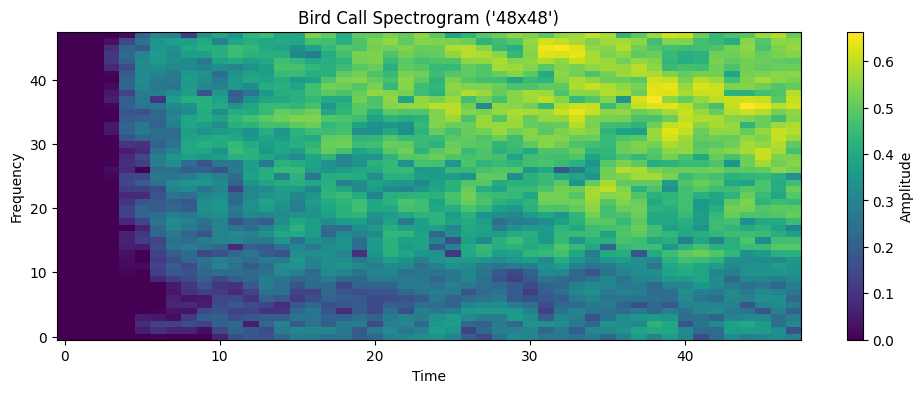

In [16]:
npy_path = "/kaggle/input/bird-call-spectrogram/spec_train/asbfly/XC175797.npy"
image = np.load(npy_path)
#Shorter image

# Visualize the spectrogram
plt.figure(figsize=(12, 4))
plt.imshow(image[:48, :48], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title("Bird Call Spectrogram ('48x48')")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


(1, 48, 48, 1)
Image shape: (1, 48, 48, 1)
Patches shape: (1, 9, 256)


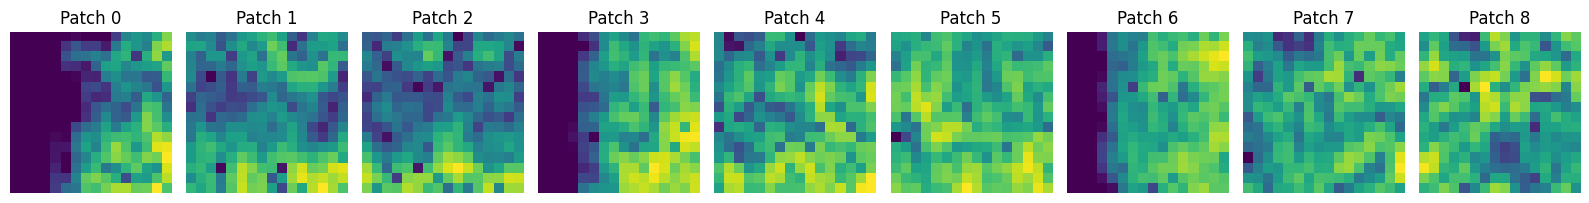

In [17]:
height, width = 48, 48
patch_size = 16

image_batch = tf.expand_dims(tf.constant(image[:height, :width], dtype=tf.float32), 0)
image_batch = tf.expand_dims(image_batch, axis=-1)
print(image_batch.shape)
patch_layer = Patches(patch_size)
patches = patch_layer(image_batch)
print(f"Image shape: {image_batch.shape}")  # Should be (1, 32, 32, 1)
print(f"Patches shape: {patches.shape}")  # Should be (1, 4, 256)


fig, axes = plt.subplots(1, 9, figsize=(16, 4))
for patch_idx in range(9):  # You have 5 patches
    # Get and reshape patch
    flat_patch = patches[0, patch_idx, :]
    patch_2d = tf.reshape(flat_patch, [patch_size, patch_size])
    
    # Plot
    axes[patch_idx].imshow(patch_2d, cmap='viridis')
    axes[patch_idx].set_title(f'Patch {patch_idx}')
    axes[patch_idx].axis('off')

plt.tight_layout()
plt.show()

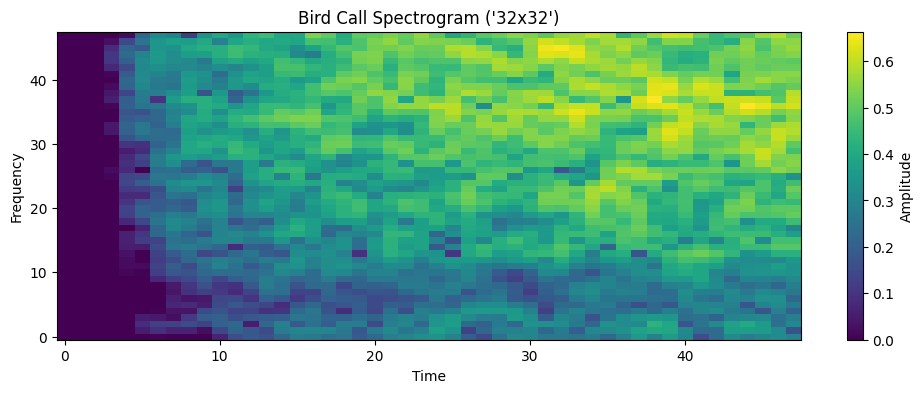

In [18]:
# Create reconstruction layer
recon_layer = PatchReconstruction(patch_size=patch_size, 
                                  img_height=height, 
                                  img_width=width, 
                                  channels=1)

# Reconstruct the image
reconstructed = recon_layer(patches)

# Visualize the spectrogram
plt.figure(figsize=(12, 4))
plt.imshow(reconstructed[0, :, :, 0], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title("Bird Call Spectrogram ('32x32')")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

# Patch Blinding

In [19]:
# TRUE MAE MASKING FUNCTION (FIXED - TensorFlow compatible)
def create_mae_mask(batch_size, num_patches, mask_ratio):
    """
    Create MAE-style mask for each item in batch
    Creates different random masks for each item in the batch.
    
    Args:
        batch_size: Number of items in batch
        num_patches: Total number of patches
        mask_ratio: Fraction of patches to mask
    
    Returns:
        keep_indices: [batch, num_keep] - sorted indices of visible patches, by default patches indexes go row by row.
        mask_indices: [batch, num_mask] - sorted indices of masked patches, by default patches indexes go row by row.
    
    Example:
        batch_size=2, num_patches=10, mask_ratio=0.5
        Returns:
          keep_indices: [[0,2,4,6,8], [1,3,5,7,9]]  # 5 kept per image sample
          mask_indices: [[1,3,5,7,9], [0,2,4,6,8]]  # 5 masked per image sample
    """
    num_keep = tf.cast(tf.cast(num_patches, tf.float32) * (1.0 - mask_ratio), tf.int32) #Raw number of masks kept
    
    # Generate random noise for each batch item and patch: Shape: [batch_size, num_patches]
    noise = tf.random.uniform([batch_size, num_patches], minval=0, maxval=1) # Round up allways
    
    # Sort indices by noise values (creates random permutation per batch item) TensorFlow-compatible
    # argsort gives us the indices that would sort the noise:
    # e.g. batch size = 1
    #noise =  [[0.3, 0.9, 0.1, 0.7, 0.5, 0.2, 0.8, 0.4, 0.6, 0.0],  # Batch item 0
            #[0.6, 0.2, 0.8, 0.1, 0.9, 0.5, 0.3, 0.7, 0.4, 0.0]]  # Batch item 1
    #shuffled_indices = [[9, 2, 5, 0, 7, 4, 8, 3, 6, 1],  # Batch item 0
    #                   [9, 3, 1, 6, 8, 5, 0, 2, 4]]

    shuffled_indices = tf.argsort(noise, axis=1)

    # Split the into keep and mask indices from the ratio% of the shuffled_indices.
    keep_indices = tf.sort(shuffled_indices[:, :num_keep], axis=1)
    mask_indices = tf.sort(shuffled_indices[:, num_keep:], axis=1)
    
    return keep_indices, mask_indices

## Patch Blinding - Test

Total patches: 9
Visible: 2
Masked: 7


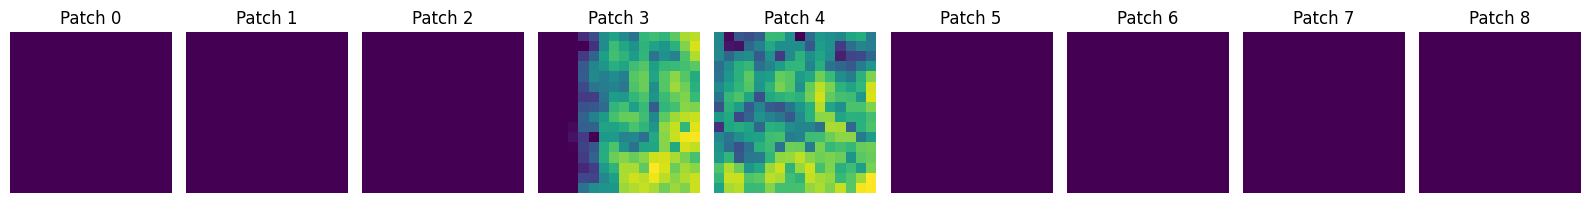

In [20]:
batch_size = patches.shape[0]
num_patches = patches.shape[1]
mask_ratio = 0.75
keep_idxs, masked_idxs = create_mae_mask(1, 9, 0.75)

print(f"Total patches: {num_patches}")
print(f"Visible: {keep_idxs.shape[1]}")
print(f"Masked: {masked_idxs.shape[1]}")

patches_masked = patches.numpy().copy()

for masked_idx in masked_idxs[0].numpy():
    patches_masked[0, masked_idx, :] = 0

patches_masked.shape

fig, axes = plt.subplots(1, 9, figsize=(16, 4))
for patch_idx in range(9):  # You have 5 patches
    # Get and reshape patch
    flat_patch = patches_masked[0, patch_idx, :]
    patch_2d = tf.reshape(flat_patch, [patch_size, patch_size])
    
    # Plot
    axes[patch_idx].imshow(patch_2d, cmap='viridis')
    axes[patch_idx].set_title(f'Patch {patch_idx}')
    axes[patch_idx].axis('off')

plt.tight_layout()
plt.show()
    
# #https://www.geeksforgeeks.org/python/python-tensorflow-gather/
visible_patches = tf.gather(patches, keep_idxs, axis=1, batch_dims=1)
masked_patches = tf.gather(patches, masked_idxs, axis=1, batch_dims=1)

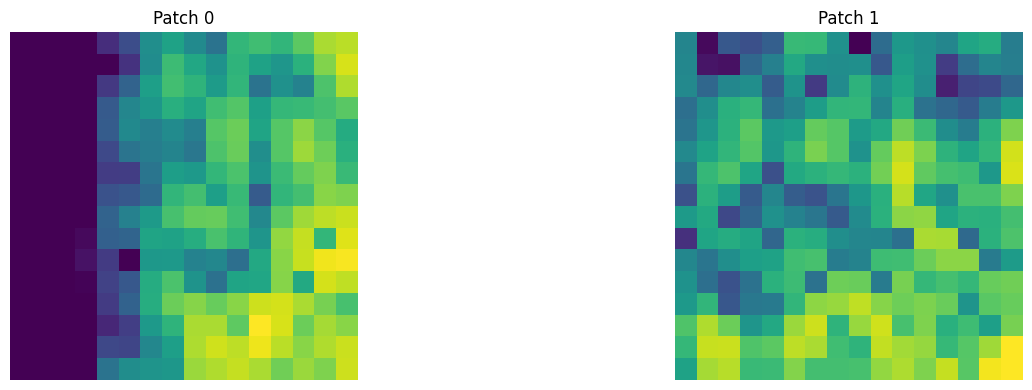

In [21]:
fig, axes = plt.subplots(1, visible_patches.shape[1], figsize=(16, 4))
for patch_idx in range(visible_patches.shape[1]):  # You have 5 patches
    # Get and reshape patch
    flat_patch = visible_patches[0, patch_idx, :]
    patch_2d = tf.reshape(flat_patch, [patch_size, patch_size])
    
    # Plot
    axes[patch_idx].imshow(patch_2d, cmap='viridis')
    axes[patch_idx].set_title(f'Patch {patch_idx}')
    axes[patch_idx].axis('off')

plt.tight_layout()
plt.show()

# Patch Encoder

In [22]:
#Inspired by: https://towardsdatascience.com/how-to-implement-state-of-the-art-masked-autoencoders-mae-6f454b736087/
class MAEPatchEncoder(layers.Layer):
    """Encode only visible patches with positional embeddings"""
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        
    def build(self, input_shape):
        self.projection = layers.Dense(units=self.projection_dim, name='projection')
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, 
            output_dim=self.projection_dim,
            name='position_embedding'
        )
        super().build(input_shape)
    
    def call(self, patches, keep_indices):
        # Mimicking steps from: https://towardsdatascience.com/how-to-implement-state-of-the-art-masked-autoencoders-mae-6f454b736087/
        """
        input:
            patches: [batch, num_patches, patch_dim] - all batches
            keep_indices: [batch, num_keep] - indices of patches to encode, output from create_mae_mask
        
        Returns:
            [batch, num_keep, projection_dim]
        """
        # batch_size = tf.shape(patches)[0]
        # num_keep = tf.shape(keep_indices)[1]
        
        # # Gather visible patches for each batch item
        # batch_indices = tf.repeat(tf.range(batch_size)[:, None], num_keep, axis=1)
        # gather_indices = tf.stack([batch_indices, keep_indices], axis=-1)
        # visible_patches = tf.gather_nd(patches, gather_indices)
        visible_patches = tf.gather(patches, keep_indices, axis=1, batch_dims=1)
        
        # Project to embedding space
        projected = self.projection(visible_patches)
        
        # Add positional embeddings across batch
        position_emb = self.position_embedding(keep_indices[0])  # Use first batch's positions
        encoded = projected + position_emb
        
        return encoded
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim
        })
        return config

## Patch Encoder - Test

In [23]:
num_batches = 1
projection_dim = 512

encoder = MAEPatchEncoder(num_patches=num_patches, projection_dim=projection_dim)
encoded = encoder(patches, keep_idxs)
print(f"Output:")
print(f"  encoded.shape: {encoded.shape}")
print(f"  Expected shape: ({num_batches}, {keep_idxs.shape[1]}, {projection_dim})")


print(f"Projection Output:")
visible_patches_manual = tf.gather(patches, keep_idxs, axis=1, batch_dims=1)
print(f"  visible_patches shape: {visible_patches_manual.shape}")
projected_manual = encoder.projection(visible_patches_manual)
print(f"  projected shape: {projected_manual.shape}")


print(f"Positional Embedding:")
position_emb = encoder.position_embedding(keep_idxs[0])
print(f"  position_emb.shape: {position_emb.shape}")
expected_encoded = projected_manual + position_emb
difference = tf.reduce_max(tf.abs(encoded - expected_encoded))
print(difference)

Output:
  encoded.shape: (1, 2, 512)
  Expected shape: (1, 2, 512)
Projection Output:
  visible_patches shape: (1, 2, 256)
  projected shape: (1, 2, 512)
Positional Embedding:
  position_emb.shape: (2, 512)
tf.Tensor(0.0, shape=(), dtype=float32)


# MAE Model

## Encoder

In [24]:
class MAEEncoder(layers.Layer):
    """Transformer or MLP encoder for MAE"""
    
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.config = config
        
        # Encoder layers
        self.encoder_layers = []
        if config.num_heads == 0:
            # MLP encoder
            print(f"Building MLP encoder with {config.num_layers} layers.")
            for layer in range(config.num_layers):
                # https://arxiv.org/html/2510.12819v1 justifies using gelu and dropout
                self.encoder_layers.append({
                    'dense': layers.Dense(config.hidden_dim, activation='gelu', name=f'encoder_dense_{layer}'),
                    'norm': layers.LayerNormalization(epsilon=1e-6, name=f'encoder_norm_{layer}'),
                    'drop': layers.Dropout(0.1, name=f'encoder_drop_{layer}')
                })
        else:
            # Transformer encoder
            print(f"Building Transformer encoder with {config.num_layers} layers, {config.num_heads} attention heads.")
            for layer in range(config.num_layers):
                # Transformer block/layer taken from:https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
                self.encoder_layers.append({
                    'norm1': layers.LayerNormalization(epsilon=1e-6, name=f'encoder_norm1_{layer}'),
                    'attn': layers.MultiHeadAttention(num_heads=config.num_heads, 
                                                      key_dim=config.hidden_dim // config.num_heads,
                                                      dropout=0.1, 
                                                      name=f'encoder_attn_{layer}'),
                    'add1': layers.Add(name=f'encoder_add1_{layer}'),
                    'norm2': layers.LayerNormalization(epsilon=1e-6, name=f'encoder_norm2_{layer}'),
                    'mlp1': layers.Dense(config.hidden_dim * 4, activation='gelu', name=f'encoder_mlp1_{layer}'),
                    'mlp2': layers.Dense(config.hidden_dim, name=f'encoder_mlp2_{layer}'),
                    'drop': layers.Dropout(0.1, name=f'encoder_drop_{layer}'),
                    'add2': layers.Add(name=f'encoder_add2_{layer}')
                })
        
        self.encoder_norm = layers.LayerNormalization(epsilon=1e-6, name='encoder_output')
    
    def call(self, encoded, training=False):
        """
        Args:
            encoded: [batch, num_visible_patches, hidden_dim]
            training: Boolean for dropout
        
        Returns:
            [batch, num_visible_patches, hidden_dim]
        """
        if self.config.num_heads == 0:
            # MLP encoder
            for layer in self.encoder_layers:
                encoded = layer['dense'](encoded)
                encoded = layer['norm'](encoded)
                encoded = layer['drop'](encoded, training=training)
        else:
            # Transformer encoder (Pre-LN)
            for layer in self.encoder_layers:
                # Attention block
                x1 = layer['norm1'](encoded)
                attn = layer['attn'](x1, x1, training=training)
                x2 = layer['add1']([attn, encoded])
                
                # MLP block
                x3 = layer['norm2'](x2)
                x3 = layer['mlp1'](x3)
                x3 = layer['mlp2'](x3)
                x3 = layer['drop'](x3, training=training)
                encoded = layer['add2']([x3, x2])
        
        # Final normalization
        encoded = self.encoder_norm(encoded)
        
        return encoded

## Decoder

### Idea and Implementation

In [25]:
# projection_dim   
patches2 = tf.random.normal([batch_size, num_patches, 512])
visible_patches2 = tf.gather(patches2, keep_idxs, axis=1, batch_dims=1)

for patch in range(num_patches):
    patches2 = tf.tensor_scatter_nd_update(patches2, 
                                          [[0, patch, 0]], 
                                          [float(patch)])
num_masked_patches = masked_idxs.shape[1]
#make a temporal embedding of feature vector size for masked embeddings.
mask_embedding = tf.constant([[[-99.0] + [0.0]*(projection_dim-1)]], dtype=tf.float32)
#make 1-rate copies of this placeholder
mask_embeddings = tf.tile(mask_embedding, [batch_size, num_masked_patches, 1])
#concatenate the patches embeddings of size (feature vector len) with the generated masked patch embedding
full_tokens = tf.concat([visible_patches2, mask_embeddings], axis=1)
#concatenate the patches embeddings indexes
full_indices = tf.concat([keep_idxs, masked_idxs], axis=1)

#sort indices and sort the embeddings.
sorted_indices = tf.argsort(full_indices, axis=1)
full_embeddings_sorted = tf.gather(full_tokens, sorted_indices, axis=1, batch_dims=1)
full_indices, sorted_indices, full_embeddings_sorted

(<tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[3, 4, 0, 1, 2, 5, 6, 7, 8]], dtype=int32)>,
 <tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[2, 3, 4, 0, 1, 5, 6, 7, 8]], dtype=int32)>,
 <tf.Tensor: shape=(1, 9, 512), dtype=float32, numpy=
 array([[[-99.,   0.,   0., ...,   0.,   0.,   0.],
         [-99.,   0.,   0., ...,   0.,   0.,   0.],
         [-99.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [-99.,   0.,   0., ...,   0.,   0.,   0.],
         [-99.,   0.,   0., ...,   0.,   0.,   0.],
         [-99.,   0.,   0., ...,   0.,   0.,   0.]]], dtype=float32)>)

### Decoder Design

In [26]:
class MAEDecoder(layers.Layer):
    """Transformer or MLP decoder for MAE"""
    
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.config = config
        
        # Learnable mask token - TO keep track of the added ptches that replace the missing/masked ones from the input
        self.mask_token = None  # Will be created in build()
        
        # Decoder positional embeddings - now for all image pathces and not for only input patches
        self.decoder_pos_emb = layers.Embedding(input_dim=config.num_patches, 
                                                output_dim=config.hidden_dim, 
                                                name='decoder_pos_embedding',)
        
        # Decoder layers (shallower than encoder)
        num_decoder_layers = max(1, config.num_layers // 2)
        self.decoder_layers = []
        
        if config.num_heads == 0:
            # MLP decoder
            print(f"Building MLP decoder with {num_decoder_layers} layers.")
            for layer in range(num_decoder_layers):
                self.decoder_layers.append({
                    'dense': layers.Dense(config.hidden_dim, activation='gelu', name=f'decoder_dense_{layer}'),
                    'norm': layers.LayerNormalization(epsilon=1e-6, name=f'decoder_norm_{layer}'),
                    'drop': layers.Dropout(0.1, name=f'decoder_drop_{layer}')
                })
        else:
            # Transformer decoder
            print(f"Building Transformer decoder with {num_decoder_layers} layers.")
            for layer in range(num_decoder_layers):
                self.decoder_layers.append({
                    'norm1': layers.LayerNormalization(epsilon=1e-6, name=f'decoder_norm1_{layer}'),
                    'attn': layers.MultiHeadAttention(num_heads=config.num_heads, 
                                                      key_dim=config.hidden_dim // config.num_heads, 
                                                      dropout=0.1, name=f'decoder_attn_{layer}'),
                    'add1': layers.Add(name=f'decoder_add1_{layer}'),
                    'norm2': layers.LayerNormalization(epsilon=1e-6, name=f'decoder_norm2_{layer}'),
                    'mlp1': layers.Dense(config.hidden_dim * 4, activation='gelu', name=f'decoder_mlp1_{layer}'),
                    'mlp2': layers.Dense(config.hidden_dim, name=f'decoder_mlp2_{layer}'),
                    'drop': layers.Dropout(0.1, name=f'decoder_drop_{layer}'),
                    'add2': layers.Add(name=f'decoder_add2_{layer}')
                })
        
        # Patch reconstruction projection, converts abstract decoder features back into actual pixel values.
        # convert from feature size to flattened patch size.
        patch_dim = config.patch_size * config.patch_size * 1
        self.patch_projection = layers.Dense(patch_dim, 
                                             activation='sigmoid',
                                             name='patch_reconstruction',)
    
    def build(self, input_shape):
        # Create learnable mask embedding to represent 
        self.mask_token = self.add_weight(
            shape=(1, 1, self.config.hidden_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='mask_token'
        )
        super().build(input_shape)
    
    def call(self, encoded, keep_indices, mask_indices, training=False):
        """
        Args:
            encoded: [batch, num_visible, hidden_dim] - encoded visible patches
            keep_indices: [batch, num_visible] - indices of visible patches
            mask_indices: [batch, num_masked] - indices of masked patches
            training: Boolean for dropout
        
        Returns:
            [batch, num_patches, patch_dim] - reconstructed patches
        """
        batch_size = tf.shape(encoded)[0]
        num_mask = tf.shape(mask_indices)[1]

        #make 1-rate copies of initialized embedding
        
        # Create mask tokens for masked positions along each batche's blinded patches.
        mask_embeddings = tf.tile(self.mask_token, [batch_size, num_mask, 1])

        #concatenate the patches embeddings of size (feature vector len) with the generated masked patch embedding
        full_tokens = tf.concat([encoded, mask_embeddings], axis=1)
        #concatenate the patches embeddings indexes
        full_indices = tf.concat([keep_indices, mask_indices], axis=1)
        
        #sort indices and sort the embeddings.
        sorted_indices = tf.argsort(full_indices, axis=1)
        full_tokens = tf.gather(full_tokens, sorted_indices, axis=1, batch_dims=1)
        
        #add decoder positional embeddings
        positions = tf.range(self.config.num_patches)
        pos_emb = self.decoder_pos_emb(positions)
        decoded = full_tokens + pos_emb
        
        #Process through decoder layers
        if self.config.num_heads == 0:
            # MLP decoder
            for layer in self.decoder_layers:
                decoded = layer['dense'](decoded)
                decoded = layer['norm'](decoded)
                decoded = layer['drop'](decoded, training=training)
        else:
            # Transformer decoder (Pre-LN)
            for layer in self.decoder_layers:
                # Attention block
                x1 = layer['norm1'](decoded)
                attn = layer['attn'](x1, x1, training=training)
                x2 = layer['add1']([attn, decoded])
                
                # MLP block
                x3 = layer['norm2'](x2)
                x3 = layer['mlp1'](x3)
                x3 = layer['mlp2'](x3)
                x3 = layer['drop'](x3, training=training)
                decoded = layer['add2']([x3, x2])
        
        #Project to patch dimensions between 0-1
        reconstructed_patches = self.patch_projection(decoded)
        
        return reconstructed_patches

## Model

In [27]:
class MAEModel(keras.Model):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.config = config
        
        # Patchify layer
        self.patchify = Patches(config.patch_size, name='patchify')
        self.patch_encoder = MAEPatchEncoder(config.num_patches, 
                                             config.hidden_dim, 
                                             name='patch_encoder')
        
        # Encoder
        self.encoder = MAEEncoder(config, name='mae_encoder')
        # Decoder
        self.decoder = MAEDecoder(config, name='mae_decoder')
        
        # Image reconstruction
        self.reconstruct = PatchDecoder(
            patch_size=config.patch_size,
            img_height=config.img_size[0],
            img_width=config.img_size[1],
            channels=1,
            name='image_reconstruction'
        )
    def call(self, inputs, training=False):
        """
        Args:
            inputs: [batch, height, width, 1] - input spectrograms
            training: Boolean for dropout
        
        Returns:
            [batch, height, width, 1] - reconstructed spectrograms
        """
        
        batch_size = tf.shape(inputs)[0]
        
        # Patchify
        patches = self.patchify(inputs)
        
        # Create random mask
        keep_indices, mask_indices = create_mae_mask(batch_size, 
                                                     self.config.num_patches, 
                                                     self.config.mask_ratio)
        
        # Encode only visible patches
        encoded = self.patch_encoder(patches, keep_indices)
        encoded = self.encoder(encoded, training=training)

        # Decode (reconstructs all patches)
        reconstructed_patches = self.decoder(encoded, 
                                             keep_indices, 
                                             mask_indices, 
                                             training=training)
        # Reconstruct image
        reconstructed_image = self.reconstruct(reconstructed_patches)

        return reconstructed_image

# Training Loop

In [28]:
# TRAINING FUNCTION
def train_true_mae_experiment(config, train_ds, val_ds):
    """Train True MAE experiment"""
    # Datasets review
    print(f"\nTrain batches: {len(train_ds)}")
    print(f"Val batches: {len(val_ds)}")

    os.makedirs('models', exist_ok=True)
    os.makedirs('logs', exist_ok=True)
    
    # Build model
    print("\nBuilding model...")
    model = MAEModel(config)

    #Cosine Decay
    steps_per_epoch = len(train_ds)
    total_steps = config.epochs * steps_per_epoch
    
    lr_schedule = CosineDecay(
        initial_learning_rate=config.learning_rate,
        decay_steps=total_steps,
        alpha=0.0)

    print(f"  Initial LR: {config.learning_rate}")
    print(f"  Total steps: {total_steps}")
    print(f"  Steps per epoch: {steps_per_epoch}")

    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    
    # Compile
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    # Callbacks
    callbacks = [
        # keras.callbacks.ReduceLROnPlateau(
        #     monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
        # ),
        keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=5, 
                                      restore_best_weights=True, 
                                      verbose=1),
        keras.callbacks.ModelCheckpoint(f'models/true_mae_{config.name}_best.keras', 
                                        monitor='val_loss', save_best_only=True, verbose=1
        ),
        keras.callbacks.CSVLogger(f'logs/true_mae_{config.name}_training.csv'),
        #keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, 
         #                              logs: logs.update({'lr': model.optimizer.learning_rate(model.optimizer.iterations).numpy()})
        #LRLogger()
    ]
    
    # Train
    print("\nStarting training...")
    history = model.fit(train_ds, 
                        validation_data=val_ds, 
                        epochs=config.epochs, 
                        callbacks=callbacks, 
                        verbose=1)
    
    # Save final model
    model.save(f'models/true_mae_{config.name}_final.keras')
    
    return model, history

# Experiment Configuration

In [29]:
from dataclasses import dataclass

@dataclass
class ExperimentConfig:
    """Configuration for MAE experiments"""
    name: str
    hidden_dim: int = 256
    num_layers: int = 2
    num_heads: int = 4
    batch_size: int = 16
    mask_ratio: float = 0.75
    learning_rate: float = 0.001
    epochs: int = 11
    seed: int = 42
    img_size: list = None
    patch_size: int = 16
    num_patches: int = None  # Will be auto-calculated
    
    def __post_init__(self):
        """Auto-calculate num_patches from img_size and patch_size"""
        # Use defaults if not provided
        if self.img_size is None:
            #self.img_size = [256, 944]
            self.img_size = [128, 512]
        
        # Calculate num_patches
        h_patches = self.img_size[0] // self.patch_size
        w_patches = self.img_size[1] // self.patch_size
        self.num_patches = h_patches * w_patches
        
        print(f"Config '{self.name}':")
        print(f"  Image size: {self.img_size}")
        print(f"  Patch size: {self.patch_size}")
        print(f"  Patches: {h_patches} x {w_patches} = {self.num_patches}")

In [30]:
EXPERIMENTS = [
    # Phase 1: MLP Baseline (no attention heads)
    ExperimentConfig("mae_mlp_mask50_10secs", hidden_dim=256, num_layers=2, num_heads=0, 
                     batch_size=64, mask_ratio=0.50),
    ExperimentConfig("mae_mlp_mask75_10secs", hidden_dim=256, num_layers=2, num_heads=0, 
                     batch_size=64, mask_ratio=0.75),
    
    # Phase 2: Small Transformer
    ExperimentConfig("mae_small_mask50_4_heads_10secs", hidden_dim=256, num_layers=2, num_heads=4, 
                     batch_size=64, mask_ratio=0.50),
    ExperimentConfig("mae_small_mask75_4_heads_10secs", hidden_dim=256, num_layers=2, num_heads=4, 
                     batch_size=64, mask_ratio=0.75),
    
    # Phase 3: Medium Transformer
    ExperimentConfig("mae_medium_mask50_6_heads_10secs", hidden_dim=384, num_layers=4, num_heads=6, 
                     batch_size=32, mask_ratio=0.50),
    ExperimentConfig("mae_medium_mask75_6_heads_10secs", hidden_dim=384, num_layers=4, num_heads=6, 
                     batch_size=32, mask_ratio=0.75),
    
    # Phase 4: Large Transformer
    ExperimentConfig("mae_large_mask50_8_heads_10secs", hidden_dim=512, num_layers=6, num_heads=8, 
                     batch_size=16, mask_ratio=0.50),
    ExperimentConfig("mae_large_mask75_8_heads_10secs", hidden_dim=512, num_layers=6, num_heads=8, 
                     batch_size=16, mask_ratio=0.75),
]

Config 'mae_mlp_mask50_10secs':
  Image size: [128, 512]
  Patch size: 16
  Patches: 8 x 32 = 256
Config 'mae_mlp_mask75_10secs':
  Image size: [128, 512]
  Patch size: 16
  Patches: 8 x 32 = 256
Config 'mae_small_mask50_4_heads_10secs':
  Image size: [128, 512]
  Patch size: 16
  Patches: 8 x 32 = 256
Config 'mae_small_mask75_4_heads_10secs':
  Image size: [128, 512]
  Patch size: 16
  Patches: 8 x 32 = 256
Config 'mae_medium_mask50_6_heads_10secs':
  Image size: [128, 512]
  Patch size: 16
  Patches: 8 x 32 = 256
Config 'mae_medium_mask75_6_heads_10secs':
  Image size: [128, 512]
  Patch size: 16
  Patches: 8 x 32 = 256
Config 'mae_large_mask50_8_heads_10secs':
  Image size: [128, 512]
  Patch size: 16
  Patches: 8 x 32 = 256
Config 'mae_large_mask75_8_heads_10secs':
  Image size: [128, 512]
  Patch size: 16
  Patches: 8 x 32 = 256


In [31]:
K.clear_session()
# model, history = train_true_mae_experiment(EXPERIMENTS[0], train_ds, val_ds)

In [32]:
# model, history = train_true_mae_experiment(EXPERIMENTS[1], train_ds, val_ds)

In [33]:
# model, history = train_true_mae_experiment(EXPERIMENTS[2], train_ds, val_ds)

In [34]:
# model, history = train_true_mae_experiment(EXPERIMENTS[3], train_ds, val_ds)

In [35]:
# model, history = train_true_mae_experiment(EXPERIMENTS[4], train_ds, val_ds)

In [36]:
# model, history = train_true_mae_experiment(EXPERIMENTS[5], train_ds, val_ds)

In [37]:
# model, history = train_true_mae_experiment(EXPERIMENTS[6], train_ds, val_ds)

In [38]:
model, history = train_true_mae_experiment(EXPERIMENTS[7], train_ds, val_ds)


Train batches: 306
Val batches: 77

Building model...
Building Transformer encoder with 6 layers, 8 attention heads.
Building Transformer decoder with 3 layers.
  Initial LR: 0.001
  Total steps: 3366
  Steps per epoch: 306

Starting training...
Epoch 1/11


I0000 00:00:1765913716.617900      61 service.cc:148] XLA service 0x7f310c4a9960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765913716.618916      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765913716.618937      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765913719.862288      61 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765913741.813237      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - loss: 0.0485 - mae: 0.1609
Epoch 1: val_loss improved from inf to 0.01586, saving model to models/true_mae_mae_large_mask75_8_heads_10secs_best.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 303s 820ms/step - loss: 0.0484 - mae: 0.1608 - val_loss: 0.0159 - val_mae: 0.0884
Epoch 2/11
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - loss: 0.0136 - mae: 0.0813
Epoch 2: val_loss improved from 0.01586 to 0.01110, saving model to models/true_mae_mae_large_mask75_8_heads_10secs_best.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 211s 685ms/step - loss: 0.0136 - mae: 0.0813 - val_loss: 0.0111 - val_mae: 0.0729
Epoch 3/11
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - loss: 0.0093 - mae: 0.0654
Epoch 3: val_loss improved from 0.01110 to 0.00859, saving model to models/true_mae_mae_large_mask75_8_heads_10secs_best.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 210s 683ms/step - loss: 0.0093 - mae: 0.0654 - val_loss: 0.0086 - val_mae: 0.0619
Epoch 4/11
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/ste